In [3]:
from IPython.display import clear_output
!pip install seaborn
clear_output()

In [4]:
import numpy as np
import pandas as pd
from itertools import combinations
from tqdm import tqdm
from pprint import pprint
#import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/MyDrive/Colab Notebooks/datasets/titanic"
%cd "/content/gdrive/MyDrive/Colab Notebooks/wd/argumentation/titanic"
!pwd

Mounted at /content/gdrive
test.csv  train.csv
/content/gdrive/MyDrive/Colab Notebooks/wd/argumentation/titanic
/content/gdrive/MyDrive/Colab Notebooks/wd/argumentation/titanic


In [6]:
train_data = pd.read_csv("datasets/titanic/train.csv")
test_data = pd.read_csv("datasets/titanic/test.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Preprocessing from https://www.kaggle.com/saraswat40/titanic-simple-tensorflow-neural-network


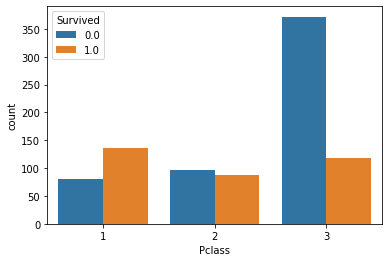

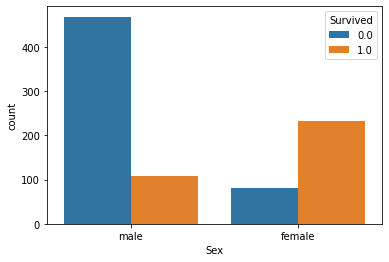

In [ ]:
# Data pre-analysis: Kaggle
train_test_combined = pd.concat([train_data, test_data], axis=0, sort=True)

sns.countplot(x='Pclass', data=train_test_combined, hue='Survived')
plt.xticks
plt.show()

sns.countplot(x='Sex', data=train_test_combined, hue='Survived')
plt.xticks
plt.show()

In [7]:
# Data cleanup: Kaggle
train_data_clean1 = train_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Embarked', 'Cabin'])
test_data_clean1 = test_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Embarked', 'Cabin'])
train_data_clean1.head()

# Missing values in data
print("Missing values in train:")
print(train_data_clean1.isnull().sum())
print("Missing values in test:")
print(test_data_clean1.isnull().sum())

# Replace missing by mean value in train
mean_age = train_data_clean1['Age'].mean()
train_data_clean2 = train_data_clean1.copy()
train_data_clean2['Age'].fillna(mean_age, inplace=True)

# Replace missing by mean value in test
test_data_clean2 = test_data_clean1.copy()
mean_age_test = test_data_clean1['Age'].mean()
test_data_clean2['Age'].fillna(mean_age_test, inplace=True)
mean_fare_test = test_data_clean1['Fare'].mean()
test_data_clean2['Fare'].fillna(mean_fare_test, inplace=True)



Missing values in train:
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
dtype: int64
Missing values in test:
Pclass     0
Sex        0
Age       86
SibSp      0
Parch      0
Fare       1
dtype: int64


In [8]:
# Quantile based discretization with pandas qcut
train_data_clean3 = train_data_clean2.copy()
train_data_clean3['disc_Fare'] = pd.qcut(train_data_clean2['Fare'], 10)
train_data_clean3['disc_Age'] = pd.qcut(train_data_clean2['Age'], 8, duplicates='drop')

y = train_data_clean3['Survived']
train_data_clean3 = train_data_clean3.drop(columns=['Survived', 'Age', 'Fare'])

oh_enc = OneHotEncoder(handle_unknown='ignore', sparse=True)
X = oh_enc.fit_transform(train_data_clean3).todok()
feature_names = oh_enc.get_feature_names_out(train_data_clean3.columns)
t_X = X.transpose().toarray()
print(X.shape)

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names_out'

In [7]:
# Arg gen

instances_by_feature = {}

for i, col in enumerate(t_X):
    instances_by_feature.update({i: list(np.where(col)[0])})

print(instances_by_feature)

# Coverage
covi_by_arg = dict()
covc_by_arg = dict()

def generate_args_lenN(n, ibyf, dataset, predictions, minimals=None):
    """
    Generates arguments of length n, given arguments of length 1.. n-1
    :param n: length of arguments to be generated
    :param ibyf: instances_by_feature
    :param predictions:
    :param minimals: arguments (minimal)
    :return:
    """

    def is_minimal(potential_arg, cl, minimals, n):
        # cl is class
        set_potential_arg = set(potential_arg)
        for k in range(n):
            for comb_ in combinations(potential_arg, k+1):
                if frozenset(comb_) in minimals[cl][k]:
                    return False
        return True

    if minimals is None:
        minimals = ([], [])
    assert len(minimals[0]) == n-1
    minimals[0].append(set())
    minimals[1].append(set())

    args = [set(), set()]
    potential_args_checked_count = 0
    for i, row in enumerate(dataset):
        for potential_arg in combinations(np.where(row)[0], n):
            cl = predictions[i]
            potential_args_checked_count += 1
            if not is_minimal(potential_arg, cl, minimals, n-1):
                continue
            selection = set.intersection(*[set(ibyf[w]) for w in potential_arg])  # all rows with all features of potential argument
            selection_preds = [predictions[i_] for i_ in selection]
            if selection_preds[:-1] == selection_preds[1:]:
                    args[selection_preds[0]].add(frozenset(potential_arg))
                    covi_by_arg.update({frozenset(potential_arg): selection}) #covi
                    minimals[cl][n-1].add(frozenset(potential_arg))
                    covc_by_arg.update({frozenset(potential_arg): set(selection_preds)}) #covc
    print(potential_args_checked_count, ' potential arg checked.')
    return args, minimals

  

def read_args(minimals, feature_names):
    arguments = [[], []]
    for cl in range(len(minimals)):
        for a in range(len(minimals[cl])):
            for f in minimals[cl][a]:
                arguments[cl].append(tuple([feature_names[k] for k in f]))
    return arguments

{0: [1, 3, 6, 11, 23, 27, 30, 31, 34, 35, 52, 54, 55, 61, 62, 64, 83, 88, 92, 96, 97, 102, 110, 118, 124, 136, 137, 139, 151, 155, 166, 168, 170, 174, 177, 185, 187, 194, 195, 209, 215, 218, 224, 230, 245, 248, 252, 256, 257, 258, 262, 263, 268, 269, 270, 273, 275, 284, 290, 291, 295, 297, 298, 299, 305, 306, 307, 309, 310, 311, 318, 319, 325, 329, 331, 332, 334, 336, 337, 339, 341, 351, 356, 366, 369, 370, 373, 375, 377, 380, 383, 390, 393, 412, 430, 434, 435, 438, 445, 447, 449, 452, 453, 456, 457, 460, 462, 467, 475, 484, 486, 487, 492, 493, 496, 498, 504, 505, 507, 512, 513, 515, 520, 523, 527, 536, 537, 539, 540, 544, 545, 550, 555, 556, 557, 558, 571, 572, 577, 581, 583, 585, 587, 591, 599, 602, 604, 607, 609, 621, 625, 627, 630, 632, 633, 641, 645, 647, 659, 660, 662, 669, 671, 679, 681, 689, 690, 694, 698, 700, 701, 707, 708, 710, 711, 712, 716, 724, 730, 737, 740, 741, 742, 745, 748, 759, 763, 765, 766, 779, 781, 782, 789, 793, 796, 802, 806, 809, 815, 820, 822, 829, 835, 839,

In [11]:
dataset = X.toarray()
row = dataset[0]
np.where(row)[0]

array([ 2,  4,  6, 12, 19, 30])

In [ ]:
n = 0
minimals = None
print("len ", n, ":", minimals)
while not minimals or len(minimals[0][-1]) != 0 or len(minimals[1][-1]) != 0:
    n += 1
    args, minimals = generate_args_lenN(n, instances_by_feature, X.toarray(), y, minimals)
    print("len ", n, ":", minimals)

len  0 : None
5346  potential arg checked.
len  1 : ([{frozenset({10}), frozenset({18}), frozenset({11}), frozenset({16})}], [set()])
13365  potential arg checked.
len  2 : ([{frozenset({10}), frozenset({18}), frozenset({11}), frozenset({16})}, {frozenset({17, 5}), frozenset({35, 23}), frozenset({20, 14}), frozenset({23, 7}), frozenset({8, 32}), frozenset({9, 13}), frozenset({33, 19}), frozenset({8, 26}), frozenset({0, 19}), frozenset({8, 25}), frozenset({1, 19}), frozenset({17, 4}), frozenset({8, 30}), frozenset({33, 7}), frozenset({35, 20}), frozenset({34, 22}), frozenset({35, 19}), frozenset({8, 29}), frozenset({19, 6}), frozenset({8, 13}), frozenset({26, 15}), frozenset({21, 7}), frozenset({34, 19}), frozenset({6, 22}), frozenset({29, 15}), frozenset({35, 21}), frozenset({20, 13}), frozenset({4, 15}), frozenset({34, 20}), frozenset({34, 7}), frozenset({19, 13}), frozenset({22, 7}), frozenset({8, 4})}], [set(), {frozenset({8, 33}), frozenset({35, 7}), frozenset({25, 15}), frozenset(

In [ ]:
pprint(read_args(minimals, feature_names)[0])

[('SibSp_5',),
 ('Parch_6',),
 ('SibSp_8',),
 ('Parch_4',),
 ('Parch_5', 'SibSp_0'),
 ('disc_Age_(45.0, 80.0]', 'disc_Fare_(10.5, 14.454]'),
 ('disc_Fare_(7.55, 7.854]', 'Parch_2'),
 ('disc_Fare_(10.5, 14.454]', 'SibSp_2'),
 ('SibSp_3', 'disc_Age_(27.0, 29.699]'),
 ('SibSp_4', 'Parch_1'),
 ('disc_Age_(29.699, 35.0]', 'disc_Fare_(-0.001, 7.55]'),
 ('SibSp_3', 'disc_Fare_(27.0, 39.688]'),
 ('Pclass_1', 'disc_Fare_(-0.001, 7.55]'),
 ('SibSp_3', 'disc_Fare_(21.679, 27.0]'),
 ('Pclass_2', 'disc_Fare_(-0.001, 7.55]'),
 ('Parch_5', 'Sex_male'),
 ('SibSp_3', 'disc_Age_(17.0, 22.0]'),
 ('disc_Age_(29.699, 35.0]', 'SibSp_2'),
 ('disc_Age_(45.0, 80.0]', 'disc_Fare_(7.55, 7.854]'),
 ('disc_Age_(35.0, 45.0]', 'disc_Fare_(8.05, 10.5]'),
 ('disc_Age_(45.0, 80.0]', 'disc_Fare_(-0.001, 7.55]'),
 ('SibSp_3', 'disc_Age_(0.419, 17.0]'),
 ('disc_Fare_(-0.001, 7.55]', 'SibSp_1'),
 ('SibSp_3', 'Parch_1'),
 ('disc_Fare_(27.0, 39.688]', 'Parch_3'),
 ('disc_Fare_(7.854, 8.05]', 'SibSp_2'),
 ('disc_Age_(35.0, 45

In [ ]:
pprint(read_args(minimals, feature_names)[1])

[('SibSp_3', 'disc_Age_(29.699, 35.0]'),
 ('disc_Age_(45.0, 80.0]', 'SibSp_2'),
 ('disc_Fare_(21.679, 27.0]', 'Parch_3'),
 ('Pclass_2', 'Parch_3'),
 ('disc_Fare_(14.454, 21.679]', 'Parch_3'),
 ('disc_Age_(22.0, 27.0]', 'Parch_3'),
 ('SibSp_3', 'disc_Age_(22.0, 27.0]'),
 ('SibSp_0', 'Parch_3'),
 ('disc_Fare_(21.679, 27.0]', 'disc_Age_(17.0, 22.0]'),
 ('Parch_2', 'disc_Fare_(10.5, 14.454]'),
 ('SibSp_3', 'Pclass_2'),
 ('disc_Age_(29.699, 35.0]', 'disc_Fare_(77.958, 512.329]'),
 ('disc_Fare_(7.854, 8.05]', 'Parch_2'),
 ('disc_Fare_(27.0, 39.688]', 'disc_Age_(22.0, 27.0]'),
 ('SibSp_4', 'disc_Fare_(7.854, 8.05]'),
 ('Parch_3', 'SibSp_2'),
 ('SibSp_3', 'Parch_0'),
 ('disc_Age_(29.699, 35.0]', 'Parch_2'),
 ('disc_Age_(27.0, 29.699]', 'disc_Fare_(27.0, 39.688]', 'Sex_female'),
 ('disc_Fare_(-0.001, 7.55]', 'Sex_female', 'disc_Age_(0.419, 17.0]'),
 ('Pclass_2', 'disc_Fare_(21.679, 27.0]', 'SibSp_2'),
 ('disc_Fare_(21.679, 27.0]', 'disc_Age_(45.0, 80.0]', 'Parch_1'),
 ('Pclass_1', 'disc_Fare_(2

In [ ]:
from os import path
import networkx as nx
import pydot

def consistent(arg1, arg2, col_p_features):
    for f1, f2 in zip(list(arg1), list(arg2)):
        if f1 != f2 and col_p_feature[f1] == col_p_feature[f2]:
            return False
    return True

def build_r_atk(minimals, col_p_feature, output_path=''):
    R_atk = []
    for cl in range(2):
        for l in range(len(minimals[cl])):
            for h1 in minimals[cl][l]:
                for l2 in range(l-1):
                    for h2 in minimals[1-cl][l2]:
                        if consistent(h1, h2, col_p_feature):
                            R_atk.append((h1, h2))

    pd.to_pickle(R_atk, path.join(output_path, 'R_atk_rt2_dev.df'))


def evaluate_r_atk(minimals, col_p_feature, input_path=''):
    build_r_atk(minimals, col_p_feature, input_path)
    R_atk = pd.read_pickle(path.join(input_path, 'R_atk_rt2_dev.df'))
    print('len', len(R_atk))

    G = nx.Graph()
    G.add_edges_from(R_atk)
    #G = nx.petersen_graph()
    nx.draw(G, with_labels=True, font_weight='bold')
    nx.drawing.nx_pydot.write_dot(G, "R_atk_fig.dot")
    plt.savefig("R_atk_fig.png")
    return G

{'Pclass': {0, 1, 2}, 'Sex': {3, 4}, 'SibSp': {5, 6, 7, 8, 9, 10, 11}, 'Parch': {12, 13, 14, 15, 16, 17, 18}, 'disc_Fare': {19, 20, 21, 22, 23, 24, 25, 26, 27, 28}, 'disc_Age': {32, 33, 34, 35, 29, 30, 31}}
{0: 'Pclass', 1: 'Pclass', 2: 'Pclass', 3: 'Sex', 4: 'Sex', 5: 'SibSp', 6: 'SibSp', 7: 'SibSp', 8: 'SibSp', 9: 'SibSp', 10: 'SibSp', 11: 'SibSp', 12: 'Parch', 13: 'Parch', 14: 'Parch', 15: 'Parch', 16: 'Parch', 17: 'Parch', 18: 'Parch', 19: 'disc_Fare', 20: 'disc_Fare', 21: 'disc_Fare', 22: 'disc_Fare', 23: 'disc_Fare', 24: 'disc_Fare', 25: 'disc_Fare', 26: 'disc_Fare', 27: 'disc_Fare', 28: 'disc_Fare', 29: 'disc_Age', 30: 'disc_Age', 31: 'disc_Age', 32: 'disc_Age', 33: 'disc_Age', 34: 'disc_Age', 35: 'disc_Age'}
len 5181
[(frozenset({8, 25}),  87) (frozenset({14, 23}),  88)
 (frozenset({2, 3, 5, 12, 24}),  88) (frozenset({17, 5}),  88)
 (frozenset({33, 14}),  89) (frozenset({0, 5, 12, 27, 30}),  89)
 (frozenset({9, 21}),  90) (frozenset({35, 7}),  90)
 (frozenset({0, 32, 5, 12, 27}

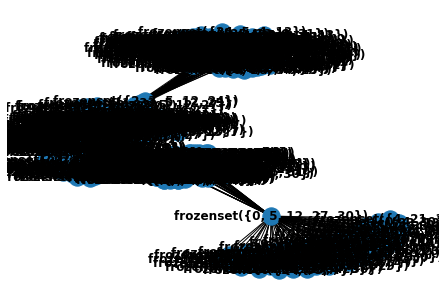

In [ ]:
# Building Attack graph

features_p_col = {}
col_p_feature = {}

for col in train_data_clean3.columns:
    features_p_col[col] = set()
    for i, f in enumerate(feature_names):
        if col in f:
            features_p_col[col].add(i)
            col_p_feature[i] = col

print(features_p_col)
print(col_p_feature)

G = evaluate_r_atk(minimals, col_p_feature)

degs = np.array(list(G.degree()), dtype = [('node', 'object'), ('degree', int)])
degrees = np.sort(degs, order='degree')
print(degrees[-20:])


In [ ]:
# Building Naive extensions
input_path=''
R_atk = pd.read_pickle(path.join(input_path, 'R_atk_rt2_dev.df'))

all_args = set()
for cl in range(len(minimals)):
    for l in range(len(minimals[cl])):
          all_args.update(minimals[cl][l])

print(len(all_args), ' args in total.')

# Finding naive extensions can also be done by finding all maximal independent 
# sets: nx.maximal_independent_set(G) can output one random one.

naive_extensions = {}
for (h1, h2) in R_atk:
    if h1 not in naive_extensions:
        naive_extensions[h1] = all_args.copy()
    if h2 not in naive_extensions:
        naive_extensions[h2] = all_args.copy()
    naive_extensions[h1].discard(h2)
    naive_extensions[h2].discard(h1)

print(len(naive_extensions))

print(set.intersection(*naive_extensions.values()))

510  args in total.
457
{frozenset({2, 27, 29}), frozenset({35, 4, 14}), frozenset({2, 26, 13}), frozenset({2, 14, 30}), frozenset({2, 34, 13}), frozenset({25, 4, 14}), frozenset({1, 34, 14}), frozenset({8, 2, 14}), frozenset({32, 6, 23}), frozenset({1, 30, 7}), frozenset({30, 6, 23}), frozenset({1, 26, 35}), frozenset({2, 14, 7}), frozenset({1, 12, 7}), frozenset({1, 27, 5}), frozenset({1, 27, 12}), frozenset({33, 6, 23}), frozenset({1, 27, 4}), frozenset({2, 34, 23}), frozenset({2, 30, 23}), frozenset({24, 34, 14}), frozenset({32, 6, 14}), frozenset({0, 35, 14}), frozenset({2, 30, 7}), frozenset({32, 4, 14}), frozenset({1, 27, 7}), frozenset({27, 4, 14}), frozenset({35, 5, 14}), frozenset({25, 6, 14}), frozenset({32, 1, 13}), frozenset({2, 26, 5}), frozenset({25, 34, 14}), frozenset({2, 26, 30}), frozenset({2, 27, 6}), frozenset({2, 27, 14}), frozenset({26, 35, 13}), frozenset({2, 35, 6}), frozenset({26, 34, 14}), frozenset({2, 27, 34}), frozenset({1, 4, 31}), frozenset({32, 27, 14})

In [ ]:
covi_by_ext = dict()
covc_by_ext = dict()
max_covi = {}
max_covi_ext = {}

for ext in naive_extensions.values():
    covi = set.union(*[covi_by_arg[arg] for arg in ext])
    covi_by_ext.update({frozenset(ext): covi})
    if len(covi) > len(max_covi):
        max_covi_ext = ext
    covc = set.union(*[covc_by_arg[arg] for arg in ext])
    covc_by_ext.update({frozenset(ext): covc})

print(len(covi_by_ext[frozenset(max_covi_ext)]), "/", len(X))

sorted_covs = [len(cov) for cov in covi_by_ext.values()]
sorted_covs.sort()
print(sorted_covs)

for args in combinations(covi_by_ext.values(), 2):
    assert(args not in R_atk)

print("Coherence check")

print(max_covi_ext)


512 / 5346
[329, 338, 433, 444, 444, 448, 449, 450, 450, 455, 457, 457, 458, 459, 459, 459, 460, 460, 460, 460, 460, 460, 461, 461, 461, 461, 462, 462, 462, 463, 464, 465, 465, 465, 465, 465, 466, 466, 466, 466, 467, 467, 467, 469, 470, 470, 471, 471, 472, 472, 474, 478, 480, 481, 481, 482, 483, 483, 485, 487, 489, 489, 490, 490, 499, 499, 499, 500, 500, 500, 500, 501, 501, 502, 502, 502, 503, 503, 503, 503, 503, 504, 504, 504, 504, 504, 504, 505, 505, 505, 505, 506, 506, 506, 506, 507, 507, 507, 507, 507, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 511, 512]
Coherence check
{frozenset({2, 27, 29}), frozenset({19, 3, 29}), frozenset({26, 30, 7}), frozenset({24, 1, 4, 12}), frozenset({25, 12, 5, 31}), frozenset({24, 4, 7}), frozenset({32, 25, 3, 5}), frozenset({26, 34, 4, 13}), frozenset({10}), frozenset({30, 6, 23}), 

In [ ]:
def explain(instance, i, extension=max_covi_ext, covi_by_ext=covi_by_ext):
    expl = set()
    instance_set = set(np.where(instance.toarray() != 0)[1])
    if i in covi_by_ext[frozenset(extension)]:
        for arg in extension:
            if arg.issubset(instance_set):
                expl.add(arg)
    return expl

def parse_features(explanation, feature_names=feature_names):
    parsed_expl = set()
    for arg in explanation:
        parsed_expl.add(frozenset([feature_names[k] for k in arg]))
    return parsed_expl

def coverage()

In [ ]:
empty = 0
tot = 0
for k in range(X.shape[0]):
    expl = parse_features(explain(X.getrow(k), k, max_covi_ext, covi_by_ext))
    print(k, expl)
    if not expl:
        empty += 1
    tot += 1

print(empty, tot)

0 {frozenset({'SibSp_1', 'disc_Fare_(-0.001, 7.55]'})}
1 {frozenset({'disc_Fare_(39.688, 77.958]', 'Sex_female', 'Parch_0'}), frozenset({'disc_Age_(35.0, 45.0]', 'Sex_female', 'Pclass_1'}), frozenset({'Sex_female', 'Pclass_1', 'SibSp_1', 'Parch_0'}), frozenset({'disc_Fare_(39.688, 77.958]', 'Pclass_1', 'Sex_female'})}
2 set()
3 {frozenset({'disc_Fare_(39.688, 77.958]', 'disc_Age_(29.699, 35.0]', 'Sex_female'}), frozenset({'disc_Fare_(39.688, 77.958]', 'Sex_female', 'Parch_0'}), frozenset({'disc_Age_(29.699, 35.0]', 'Pclass_1', 'Sex_female'}), frozenset({'Sex_female', 'Pclass_1', 'SibSp_1', 'Parch_0'}), frozenset({'disc_Fare_(39.688, 77.958]', 'Pclass_1', 'Sex_female'})}
4 set()
5 set()
6 {frozenset({'disc_Fare_(39.688, 77.958]', 'disc_Age_(45.0, 80.0]', 'SibSp_0'})}
7 {frozenset({'SibSp_3', 'Sex_male'}), frozenset({'Parch_1', 'SibSp_3'}), frozenset({'disc_Age_(0.419, 17.0]', 'SibSp_3'})}
8 {frozenset({'disc_Fare_(10.5, 14.454]', 'disc_Age_(22.0, 27.0]', 'SibSp_0', 'Pclass_3'}), frozens

## Coverage

In [ ]:
# Compute coverages:

input_space_size = np.product([len(f_dom) for f_dom in features_p_col.values()])
print('Input space size= ', input_space_size)

def potential_arg_cov(arg):
    arg_domains = set()
    for feature in arg:
        arg_domains.add(col_p_feature[feature])
    unconstrained_cols = set(features_p_col.keys()).difference(arg_domains)
    potential_cov = np.product([len(features_p_col[uc]) for uc in unconstrained_cols])
    return potential_cov

def is_consistent(s, col_p_feature):
    return len(s) == len(set([col_p_feature[f] for f in s]))

def potential_ext_cov(set_args, max_depth=5):
    total = 0
    for k in tqdm(range(1, max_depth)):
        sub_total = 0
        for sets in combinations(ext, k):
            union_sets = set.union(*[set(fs) for fs in sets])
            if is_consistent(union_sets, col_p_feature):
                sub_total += potential_arg_cov(union_sets)
            else:
              continue
        total += (-1)**(k+1) * sub_total
        print(total)
    return total

# potential_ext_cov(max_covi_ext)




# cf DNF counting https://courses.cs.duke.edu//spring18/compsci630/lecture21.pdf

arg = list(max_covi_ext)[0]
print(arg)
print(potential_arg_cov(arg))
# print('Potential coverage for extension:', sum([potential_arg_cov(arg) for arg in max_covi_ext]))


Input space size=  20580


  0%|          | 0/4 [00:00<?, ?it/s]

73885


 50%|█████     | 2/4 [00:00<00:00,  2.82it/s]

-54385.0


 50%|█████     | 2/4 [00:37<00:37, 18.88s/it]


KeyboardInterrupt: ignored

In [ ]:
def explain(instance, extension):
    explanation = {}
    for arg in extension:
        if arg.issubset(instance):
            explanation.add(arg)

    return explanation